In [ ]:
!pip install datasets
!pip install transformers
!pip install librosa

In [ ]:
import torch
from torch import nn
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from datasets import load_dataset, load_metric
from datasets import features
from transformers import HubertForCTC
from transformers import Trainer
from transformers import TrainingArguments

Laod Dataset

In [ ]:
## KS
dataset = load_dataset("superb", "ks", revision="2.2.2")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/51094 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6798 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3081 [00:00<?, ? examples/s]

Dataset superb downloaded and prepared to /root/.cache/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 51094
    })
    validation: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 6798
    })
    test: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 3081
    })
})

In [ ]:
dataset["train"].features["label"]

ClassLabel(num_classes=12, names=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', '_silence_', '_unknown_'], id=None)

Data Distibution 

In [ ]:
num_of_each_class = np.zeros(12)

In [ ]:
for i in range(len(dataset["train"]['label'])):
  if i >= 43534:
    idx = dataset["train"]['label'][i]
    num_of_each_class[idx] += 1


In [ ]:
num_of_each_class

array([1.860e+03, 1.853e+03, 1.843e+03, 1.842e+03, 1.839e+03, 1.852e+03,
       1.864e+03, 1.839e+03, 1.885e+03, 1.861e+03, 6.000e+00, 3.255e+04])

<BarContainer object of 12 artists>

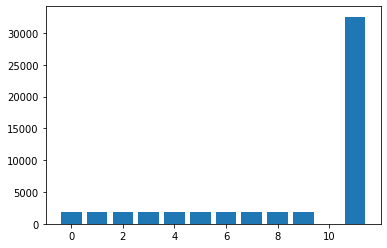

In [ ]:
plt.bar(range(12), num_of_each_class)

Delete 11th Class

In [ ]:
modified_dataset = dataset.filter(lambda example: example['label'] != 10)

  0%|          | 0/52 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
def edit_label(example):
  if example['label'] == 11:
    example['label'] = 10
  return example

modified_dataset = modified_dataset.map(edit_label)

Parameter 'function'=<function edit_label at 0x7f7062075710> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/51088 [00:00<?, ?ex/s]

  0%|          | 0/6798 [00:00<?, ?ex/s]

  0%|          | 0/2824 [00:00<?, ?ex/s]

In [ ]:
Classlabels = features.ClassLabel(num_classes=11, names=['yes', 'no', 'up', 'down', 'left','right', 'on', 'off',
                                           'stop', 'go','_unknown_'], id=None)
modified_dataset['train'].features["label"] = Classlabels
modified_dataset['test'].features["label"] = Classlabels
modified_dataset['validation'].features["label"] = Classlabels

In [ ]:
modified_dataset['train'].features["label"]

ClassLabel(num_classes=11, names=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', '_unknown_'], id=None)

In [ ]:
labels = modified_dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

Loading Model and Preprocess

In [ ]:
model_checkpoint = "facebook/wav2vec2-base"
batch_size = 32

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

In [ ]:
max_duration = 1.0  # seconds
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=int(feature_extractor.sampling_rate * max_duration), 
        truncation=True, 
    )
    return inputs

In [ ]:
encoded_dataset = modified_dataset.map(preprocess_function, remove_columns=["audio", "file"], batched=True)
encoded_dataset

  0%|          | 0/52 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 51088
    })
    validation: Dataset({
        features: ['label', 'input_values'],
        num_rows: 6798
    })
    test: Dataset({
        features: ['label', 'input_values'],
        num_rows: 2824
    })
})

In [ ]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = 11
model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint, 
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)


In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-ks",
    evaluation_strategy = "steps",
    save_strategy = "steps",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    save_steps=1000,
    eval_steps=250,
    logging_steps=250,
    #load_best_model_at_end=True,
    #metric_for_best_model="accuracy",
    #push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
metric_accuracy = load_metric("accuracy")
metric_precision = load_metric("precision")
metric_recall = load_metric("recall")

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = metric_accuracy.compute(predictions=predictions, references=eval_pred.label_ids)
    precision = metric_precision.compute(predictions=predictions, references=eval_pred.label_ids, average="micro")
    recall = metric_recall.compute(predictions=predictions, references=eval_pred.label_ids, average="macro")
    
    return  {"accuracy": accuracy, "precision": precision, "recall": recall}

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        num_classes = np.array([1.860e+03, 1.853e+03, 1.843e+03, 1.842e+03, 1.839e+03, 1.852e+03,
                                1.864e+03, 1.839e+03, 1.885e+03, 1.861e+03, 3.255e+04])
        weights = torch.tensor((1 / num_classes) * len(encoded_dataset['train']))
        loss_fct = nn.CrossEntropyLoss(weight = weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 51088
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1995


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall
250,1.620500,1.174663,{'accuracy': 0.6435716387172697},{'precision': 0.6435716387172697},{'recall': 0.17692124676732887}
500,0.835100,0.485270,{'accuracy': 0.9058546631362165},{'precision': 0.9058546631362165},{'recall': 0.7820163546652542}
750,0.453300,0.238357,{'accuracy': 0.9714621947631656},{'precision': 0.9714621947631656},{'recall': 0.9442624928943648}
1000,0.282200,0.157032,{'accuracy': 0.9760223595175052},{'precision': 0.9760223595175052},{'recall': 0.9595442772162422}
1250,0.224100,0.120624,{'accuracy': 0.9807296263606943},{'precision': 0.9807296263606943},{'recall': 0.9585318315067565}
1500,0.186800,0.109051,{'accuracy': 0.9788172992056487},{'precision': 0.9788172992056487},{'recall': 0.9625913847749102}
1750,0.156600,0.108932,{'accuracy': 0.9777875845837011},{'precision': 0.9777875845837011},{'recall': 0.9621147535700308}


***** Running Evaluation *****
  Num examples = 6798
  Batch size = 32
Trainer is attempting to log a value of "{'accuracy': 0.6435716387172697}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6435716387172697}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.17692124676732887}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 6798
  Batch size = 32
Trainer is attempting to log a value of "{'accuracy': 0.9058546631362165}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard'

TrainOutput(global_step=1995, training_loss=0.48919495317272677, metrics={'train_runtime': 7226.7731, 'train_samples_per_second': 35.346, 'train_steps_per_second': 0.276, 'total_flos': 2.318957379827712e+18, 'train_loss': 0.48919495317272677, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 6798
  Batch size = 32


Trainer is attempting to log a value of "{'accuracy': 0.9776404824948515}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9776404824948515}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9607314233566939}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 5.0,
 'eval_accuracy': {'accuracy': 0.9776404824948515},
 'eval_loss': 0.10173899680376053,
 'eval_precision': {'precision': 0.9776404824948515},
 'eval_recall': {'recall': 0.9607314233566939},
 'eval_runtime': 72.8799,
 'eval_samples_per_second': 93.277,
 'eval_steps_per_second': 2.923}

In [ ]:
trainer.evaluate(encoded_dataset["test"])

***** Running Evaluation *****
  Num examples = 2824
  Batch size = 32


Trainer is attempting to log a value of "{'accuracy': 0.9709631728045326}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9709631728045326}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9708296177700785}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'epoch': 5.0,
 'eval_accuracy': {'accuracy': 0.9709631728045326},
 'eval_loss': 0.16030792891979218,
 'eval_precision': {'precision': 0.9709631728045326},
 'eval_recall': {'recall': 0.9708296177700785},
 'eval_runtime': 30.2363,
 'eval_samples_per_second': 93.398,
 'eval_steps_per_second': 2.943}

In [ ]:
result = trainer.predict(encoded_dataset["test"])

***** Running Prediction *****
  Num examples = 2824
  Batch size = 32


In [ ]:
true_labels = result[1]
predictions_labels = np.argmax(result[0], axis=1)

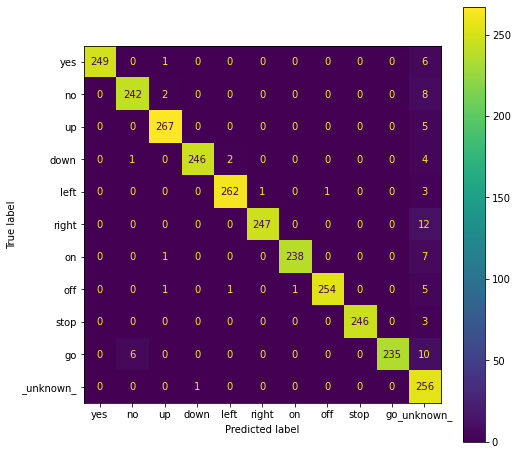

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', '_unknown_']


cm = confusion_matrix(true_labels, predictions_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)